In [1]:
import copy
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from datasets import Dataset, DatasetDict

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
train = pd.read_csv("./train.csv").sample(2000)
print(train.shape)
train.sample(5)

(2000, 6)


,id,qid1,qid2,question1,question2,is_duplicate
186133,186133,205322,284000,What is the greatest commercial you've ever seen?,What is the most impressive advertisement you ...,1
189515,189515,288292,288293,What are the career options after completing d...,What are the career options after diploma in C...,0
172385,172385,266168,266169,How can I learn to apply beautiful mehndi?,Is it unusual to have friends who are much older?,0
13467,13467,25859,25860,What are good gifts for a foreign visitor to b...,What are good gifts for a foreign visitor to b...,0
358540,358540,90922,475430,Where can I get best quality video DJ for part...,Where can I get best quality DJ for Birthday p...,1


In [3]:
print(train.isnull().sum().sum())
train.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 387702 to 366034
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2000 non-null   int64 
 1   qid1          2000 non-null   int64 
 2   qid2          2000 non-null   int64 
 3   question1     2000 non-null   object
 4   question2     2000 non-null   object
 5   is_duplicate  2000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 109.4+ KB


In [4]:
train = train[~train.isna().any(axis=1)]
print(train.isnull().sum().sum())
train.info()

0
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 387702 to 366034
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            2000 non-null   int64 
 1   qid1          2000 non-null   int64 
 2   qid2          2000 non-null   int64 
 3   question1     2000 non-null   object
 4   question2     2000 non-null   object
 5   is_duplicate  2000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 109.4+ KB


In [5]:
train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
train.sample(5)

,question1,question2,is_duplicate
127410,How can I detox from meth quickly?,How can I prevent champagne from going bad too...,0
137659,Do SSRIs affect the first and higher order mom...,Do antipsychotics affect the first and higher ...,0
152443,What is the best way to sell a used car?,What's the best way to buy a used car?,0
272441,What is commissioned education? How does it wo...,What is like to work at LG Corp. in South Korea?,0
360053,What are examples of Corporate Venture Capital...,Which are the tier 1 Corporate Venture Capital...,0


In [6]:
test = pd.read_csv("./test.csv")
print(test.shape)
test.tail(5)

(2345796, 3)


,test_id,question1,question2
2345791,2345791,How do Peaks (TV series): Why did Leland kill ...,What is the most study scene in twin peaks?
2345792,2345792,"What does be ""in transit"" mean on FedEx tracking?",How question FedEx packages delivered?
2345793,2345793,What are some famous Romanian drinks (alcoholi...,Can a non-alcoholic restaurant be a huge success?
2345794,2345794,What were the best and worst things about publ...,What are the best and worst things examination...
2345795,2345795,What is the best medication equation erectile ...,How do I out get rid of Erectile Dysfunction?


### Reading data in Hugging Face format

In [7]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=1, shuffle=False)
train_data.to_csv('train_clean.csv',index=False)
val_data.to_csv('val_clean.csv',index=False)

In [8]:
dataset = load_dataset('csv', data_files={'train': './train_clean.csv',
                                          'valid':'./val_clean.csv'},)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 1600
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate'],
        num_rows: 400
    })
})

In [9]:
model_checkpoint = "bert-base-cased"
batch_size = 32

In [10]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

#### Sample Tokenization

In [11]:
ques1 = "How do I calculate sgpa to cgpa in wbut?"
ques2 = "How can someone calculate CGPA from SGPAs in WBUT?"
tokenizer(ques1, ques2, padding='max_length',  # Pad to max_length
                        truncation=True,  # Truncate to max_length
                        max_length=100,  
                        return_tensors='tf',
                        return_token_type_ids = True)

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101,  1731,  1202,   146, 20446,   188,  1403,  4163,  1106,
          172,  1403,  4163,  1107,   192, 16442,   136,   102,  1731,
         1169,  1800, 20446,   140, 17095,  1592,  1121,   156, 17095,
        23390,  1107,   160,  2064, 16830,   136,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])>, 'token_type_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1

### Tokenization for model training

In [12]:
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length = 75)

In [13]:
dataset["train"].features

{'question1': Value(dtype='string', id=None),
 'question2': Value(dtype='string', id=None),
 'is_duplicate': Value(dtype='int64', id=None)}

In [14]:
pre_tokenizer_columns = set(dataset["train"].features)
pre_tokenizer_columns

{'is_duplicate', 'question1', 'question2'}

In [15]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

In [16]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
    valid: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 400
    })
})

In [17]:
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['input_ids', 'attention_mask', 'token_type_ids']


### Padding and Batching

In [18]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf",)


tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["is_duplicate"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

C:\Users\Ameena\anaconda3\envs\ds\lib\site-packages\datasets\arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [19]:
# sample train batch
z = next(iter(tf_train_dataset))
# sample decoded string
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] How true are the stories about Dr. Yeshi Dhonden and Tibetan medical tradition, especially regarding their treatment of ailments like cancer and AIDS? [SEP] The outcomes for cancer treatment and other chronic ailments is far better in the US than other OECD countries. What can be concluded from this? [SEP]'

In [20]:
z

({'input_ids': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
  array([[ 101, 1731, 2276, ..., 1142,  136,  102],
         [ 101, 1327, 1110, ...,    0,    0,    0],
         [ 101, 1327, 2171, ...,    0,    0,    0],
         ...,
         [ 101, 1327, 1202, ...,    0,    0,    0],
         [ 101, 1327, 1110, ...,    0,    0,    0],
         [ 101, 1327, 1110, ...,    0,    0,    0]], dtype=int64)>,
  'token_type_ids': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
  array([[0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int64)>,
  'attention_mask': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=

In [21]:
z[0]

{'input_ids': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
 array([[ 101, 1731, 2276, ..., 1142,  136,  102],
        [ 101, 1327, 1110, ...,    0,    0,    0],
        [ 101, 1327, 2171, ...,    0,    0,    0],
        ...,
        [ 101, 1327, 1202, ...,    0,    0,    0],
        [ 101, 1327, 1110, ...,    0,    0,    0],
        [ 101, 1327, 1110, ...,    0,    0,    0]], dtype=int64)>,
 'token_type_ids': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
 array([[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)>,
 'attention_mask': <tf.Tensor: shape=(32, 65), dtype=int64, numpy=
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>}

In [22]:
z[1]

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)>

In [23]:
z[0]['input_ids']

<tf.Tensor: shape=(32, 65), dtype=int64, numpy=
array([[ 101, 1731, 2276, ..., 1142,  136,  102],
       [ 101, 1327, 1110, ...,    0,    0,    0],
       [ 101, 1327, 2171, ...,    0,    0,    0],
       ...,
       [ 101, 1327, 1202, ...,    0,    0,    0],
       [ 101, 1327, 1110, ...,    0,    0,    0],
       [ 101, 1327, 1110, ...,    0,    0,    0]], dtype=int64)>

In [24]:
# sample train batch
z = next(iter(tf_train_dataset))
# sample decoded string
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] What is it like to study at McGill University? [SEP] What is it like to study chemistry at McGill University? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [25]:
z

({'input_ids': <tf.Tensor: shape=(32, 66), dtype=int64, numpy=
  array([[  101,  1327,  1110, ...,     0,     0,     0],
         [  101,  1327,  1674, ...,     0,     0,     0],
         [  101,  1327,  1132, ...,     0,     0,     0],
         ...,
         [  101,  1731,  1277, ...,     0,     0,     0],
         [  101,  1327,  1110, ...,     0,     0,     0],
         [  101,  2181, 22195, ...,     0,     0,     0]], dtype=int64)>,
  'token_type_ids': <tf.Tensor: shape=(32, 66), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int64)>,
  'attention_mask': <tf.Tensor: shape=(32, 66), dtype=int64, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
     

In [26]:
# Number of classes in the classification task
num_labels = train.is_duplicate.nunique()
num_labels

2

In [27]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = num_labels)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_epochs = 5
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

opt = Adam(learning_rate=lr_scheduler)
loss = SparseCategoricalCrossentropy(from_logits=True)

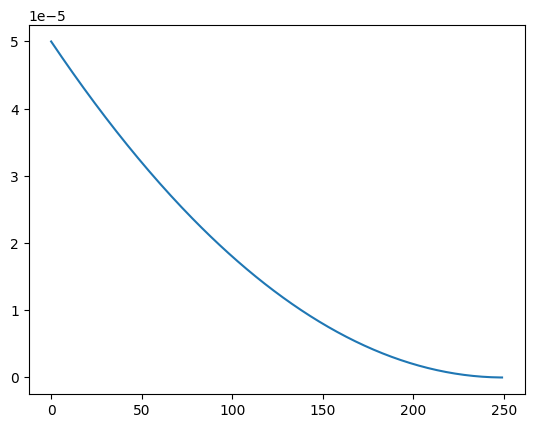

In [29]:
import matplotlib.pyplot as plt
lr_schedule = []
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr_schedule.append(lr_scheduler.initial_learning_rate * decay)

plt.plot(lr_schedule)

In [30]:
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [31]:
model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=num_epochs)

Epoch 1/5
50/50 [==============================] - 896s 17s/step - loss: 0.5779 - accuracy: 0.6294 - val_loss: 0.5304 - val_accuracy: 0.7075
Epoch 2/5
50/50 [==============================] - 845s 17s/step - loss: 0.4262 - accuracy: 0.7775 - val_loss: 0.4585 - val_accuracy: 0.7625
Epoch 3/5
50/50 [==============================] - 860s 17s/step - loss: 0.2822 - accuracy: 0.8863 - val_loss: 0.4910 - val_accuracy: 0.7525
Epoch 4/5
50/50 [==============================] - 839s 17s/step - loss: 0.1946 - accuracy: 0.9375 - val_loss: 0.5462 - val_accuracy: 0.7900
Epoch 5/5
50/50 [==============================] - 855s 17s/step - loss: 0.1707 - accuracy: 0.9513 - val_loss: 0.5615 - val_accuracy: 0.7875
